In [1]:
import json
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from io_f import read_data_file
from main import calibrate_magnetic_wifi_ibeacon_to_position, extract_magnetic_strength

## Prepare environment and read data
Adopted from the sample code

In [2]:
selected_floor = 'B1'
floor_data_dir = f'./data/site1/{selected_floor}'
path_data_dir = floor_data_dir + '/path_data_files'
floor_plan_filename = floor_data_dir + '/floor_image.png'
floor_info_filename = floor_data_dir + '/floor_info.json'

save_dir = f'./output/site1/{selected_floor}'
path_image_save_dir = save_dir + '/path_images'
step_position_image_save_dir = save_dir
magn_image_save_dir = save_dir
wifi_image_save_dir = save_dir + '/wifi_images'
ibeacon_image_save_dir = save_dir + '/ibeacon_images'
wifi_count_image_save_dir = save_dir
Path(path_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(magn_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(wifi_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(ibeacon_image_save_dir).mkdir(parents=True, exist_ok=True)

In [3]:
with open(floor_info_filename) as f:
    floor_info = json.load(f)
width_meter = floor_info["map_info"]["width"]
height_meter = floor_info["map_info"]["height"]

path_filenames = list(Path(path_data_dir).resolve().glob("*.txt"))

### Visualization of Waypoints

Han Yaodong

In [4]:
def visualize_path(path_id, waypoints, width_meter, height_meter):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.add_line(plt.Line2D(waypoints[:, 0], waypoints[:, 1], marker='.', color='grey'))
    for i, xy in enumerate(waypoints):
        ax.annotate(i + 1, xy)
    ax.set_title(f'Waypoints for {path_id} at Floor {selected_floor}')
    ax.set_xlim([0, width_meter])
    ax.set_ylim([0, height_meter])
    return fig

In [ ]:
# reading data and visualize paths
waypoints_list = []
for path_filename in path_filenames:
    path_data = read_data_file(path_filename)
    path_id = path_filename.name.split(".")[0]
    waypoints = path_data.waypoint[:, 1:3]
    waypoints_list.append(waypoints)
    
    # paths
    fig = visualize_path(path_id, waypoints, width_meter, height_meter)
    fig.savefig(f'{path_image_save_dir}/{path_id}.png')
    plt.close(fig)

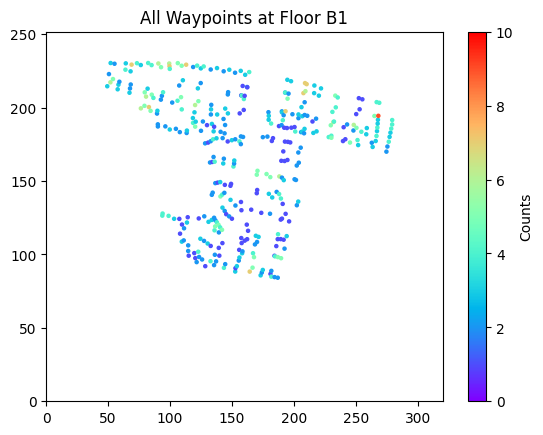

In [6]:
# visualize waypoints
all_waypoints = np.concatenate(waypoints_list)
unique_waypoints, counts = np.unique(all_waypoints, axis=0, return_counts=True)

fig = plt.figure()
ax = fig.add_subplot()
sc = plt.scatter(unique_waypoints[:, 0], unique_waypoints[:, 1], s=20, c=counts, marker='.', cmap='rainbow', vmin=0, vmax=10)
cbar = plt.colorbar(sc)
cbar.set_label("Counts")
ax.set_title(f'All Waypoints at Floor {selected_floor}')
ax.set_xlim([0, width_meter])
ax.set_ylim([0, height_meter + 20])
fig.savefig(f'{save_dir}/waypoints.png')

### Visualization of Geomagnetic Strength
Ben

In [7]:
#The following function is developed to plot the different sets of GeoMagnetic Strength X,Y,Z at same position, in order to identify the outliners
def plot_sensor_info(df, name):
    cols = ["x", "y", "z"]
    plt.subplots(1, 1, sharex='col', sharey='row', figsize=(8,5))
    plt.suptitle(name, fontsize=22)
    plt.plot(df['time'], df['z'], color='#000000', label='z_axis')
    plt.plot(df['time'], df['y'], color='#d6b258', label='y_axis')
    plt.plot(df['time'], df['x'], color='#96bcfa', label='x_axis')
    plt.xlabel('Time')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.show()

   
def revised_extract_magnetic_strength(mwi_datas):
    magnetic_strength = {}
    for position_key in mwi_datas:
        magnetic_data = mwi_datas[position_key]['magnetic']
        df = pd.DataFrame(magnetic_data, columns=['time', 'x', 'y', 'z'])
        magnetic_s = np.mean(np.sqrt(np.sum(magnetic_data[:, 1:4] ** 2, axis=1)))
        #
        #Below codes are to calculate if the X,Y,Z deviate too much across different measurement at same step positions, 
        #in order to identify noise
        #calculate mean and variance
        x_mean = np.mean(magnetic_data[:, 1])
        y_mean = np.mean(magnetic_data[:, 2])
        z_mean = np.mean(magnetic_data[:, 3])
        variance_magn_data=magnetic_data
        variance_magn_data[:, 1] -= x_mean
        variance_magn_data[:, 2] -= y_mean
        variance_magn_data[:, 3] -= z_mean
        variance_mean= np.mean(np.sqrt(np.sum(variance_magn_data[:, 1:4] ** 2, axis=1)))
        print("this is the position of below magnetic data measurement",position_key)
        print("variance is:",variance_mean)
        #
        #Set a threshold 4 such that if average variance of X,Y,Z greater than 4, 
        #such measurement is removed from the dataset, in order to create a clean and quality dataset for future training
        threshold=4
        if variance_mean < threshold:
           magnetic_strength[position_key] = magnetic_s
        #Enable line if need to capture the plot of outliner as it take long time to process 1000+ ploting.
        #if variance_mean >= threshold:
        #    #plot_sensor_info(df, "GeoMagnetic data")
        #
        #Enable below line instead of above if need to capture the plot of all X,Y,Z in different step positions
        #plot_sensor_info(df, "GeoMagnetic data")
    total_keys_before_cleanup = len(mwi_datas)
    total_keys_post_cleanup = len(magnetic_strength)
    print("total positions before cleanup are:",total_keys_before_cleanup, "total positions after removing variance>=4:",total_keys_post_cleanup)
    return magnetic_strength


In [ ]:
mwi_datas = calibrate_magnetic_wifi_ibeacon_to_position(path_filenames)

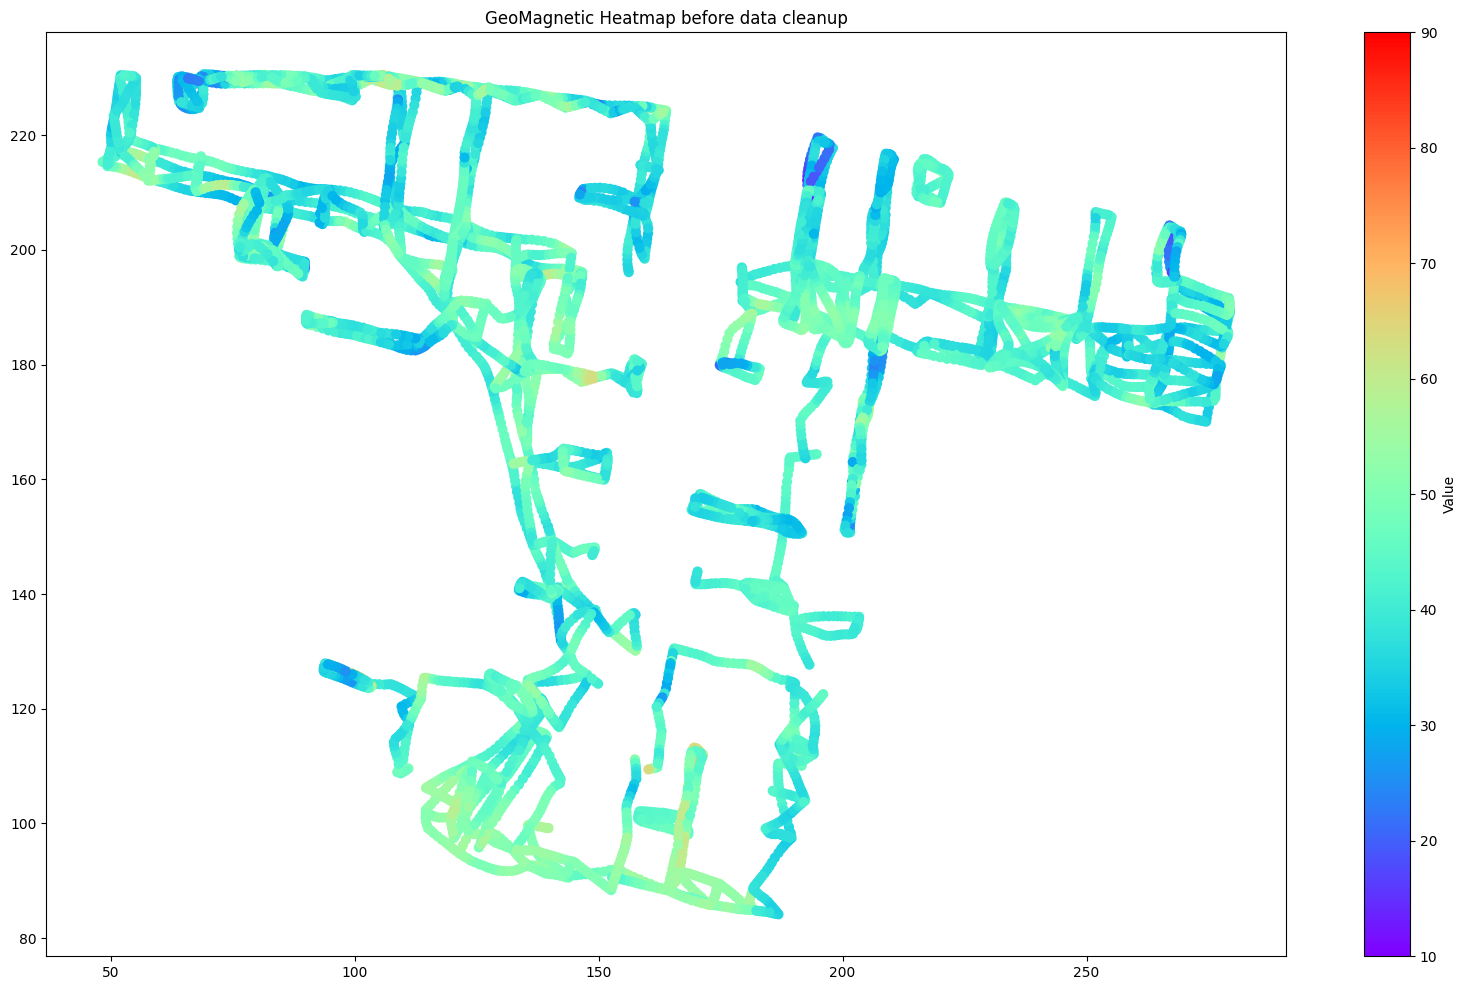

In [9]:
#visualize magnetic heatmap before data cleanup

# Define global color scale limits so all heatmaps are consistent for comparison
global_vmin = 10  # replace with your desired minimum value
global_vmax = 90   # replace with your desired maximum value
#
magnetic_strength = extract_magnetic_strength(mwi_datas)
position = np.array(list(magnetic_strength.keys()))
value = np.array(list(magnetic_strength.values()))
colorbar_title = "Value"
title = "GeoMagnetic Heatmap before data cleanup"

# Create a scatter plot
plt.figure(figsize=(20, 12))
sc = plt.scatter(position[:, 0], position[:, 1], c=value, s=40, cmap='rainbow', vmin=global_vmin, vmax=global_vmax)  

# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label(colorbar_title)

# Set the title
plt.title(title)

# Show the plot
plt.show()

In [ ]:
#visualize magnetic heatmap after data cleanup
#
# Define global color scale limits so all heat maps are consistent for comparison
global_vmin = 10  # replace with your desired minimum value
global_vmax = 90   # replace with your desired maximum value
#
new_magnetic_strength = revised_extract_magnetic_strength(mwi_datas)
position = np.array(list(new_magnetic_strength.keys()))
value = np.array(list(new_magnetic_strength.values()))
colorbar_title = "Value"
title = "GeoMagnetic Heatmap After Data Cleanup (removing those with high variance)"

# Create a scatter plot
plt.figure(figsize=(20, 12))
sc = plt.scatter(position[:, 0], position[:, 1], c=value, s=40, cmap='rainbow', vmin=global_vmin, vmax=global_vmax)  

# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label(colorbar_title)

# Set the title
plt.title(title)

# Show the plot
plt.show()

In [17]:
def loadData(floor):
    #define variables and functions from main.py
    #below floor_data_dir is set to B1, F2, F4 respectively in 3 runs
    floor_data_dir = './data/site1/' + floor
    path_data_dir = floor_data_dir + '/path_data_files'
    floor_plan_filename = floor_data_dir + '/floor_image.png'
    floor_info_filename = floor_data_dir + '/floor_info.json'
    save_dir = './output/site1/' + floor
    path_image_save_dir = save_dir + '/path_images'
    step_position_image_save_dir = save_dir
    magn_image_save_dir = save_dir

    #create output directory and read data files and file names in specific floor
    Path(path_image_save_dir).mkdir(parents=True, exist_ok=True)
    Path(magn_image_save_dir).mkdir(parents=True, exist_ok=True)
    path_filenames = list(Path(path_data_dir).resolve().glob("*.txt"))

    mwi_datas = calibrate_magnetic_wifi_ibeacon_to_position(path_filenames)
    print("loaded data for " + floor)
    return path_filenames, mwi_datas

def plotRSSIForRouter(bssid, rssi_for_router, floor):
    n = len(rssi_for_router[bssid])
    dataToPlot = np.zeros((n, 3))

    #some position has matched with multiple measurements, average them together
    for i, (loc, value) in enumerate(rssi_for_router[bssid].items()):
        dataToPlot[i][0] = loc[0]
        dataToPlot[i][1] = loc[1]
        dataToPlot[i][2] = np.mean(value)

    colorbar_title = "Average RSSI"
    title = "Average RSSI measured at bssid:" + bssid + " at " + floor
    plt.figure(figsize=(10, 6))
    sc = plt.scatter(dataToPlot[:, 0], dataToPlot[:, 1], c=dataToPlot[:, 2], s=40, cmap='rainbow')

    cbar = plt.colorbar(sc)
    cbar.set_label(colorbar_title)
    plt.title(title)
    plt.show()
    
def tidyDataForRouter(mwi_datas):
    rssi_for_router = {}
    for loc, mwi_data in mwi_datas.items():
        wifi_datas = mwi_data['wifi']
        for wifi_data in wifi_datas:
            bssid = wifi_data[2]
            rssi = int(wifi_data[3])
            if not (bssid in rssi_for_router.keys()):
                rssi_for_router[bssid] = {}
            if not (loc in rssi_for_router[bssid].keys()):
                rssi_for_router[bssid][loc] = []

            rssi_for_router[bssid][loc].append(rssi)
    return rssi_for_router

In [18]:
collectedData = {}
rssi_for_router  = tidyDataForRouter(mwi_datas)

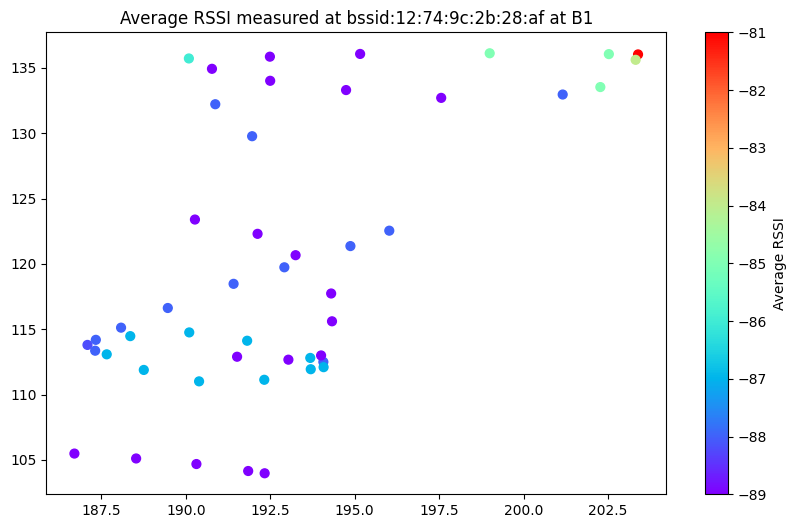

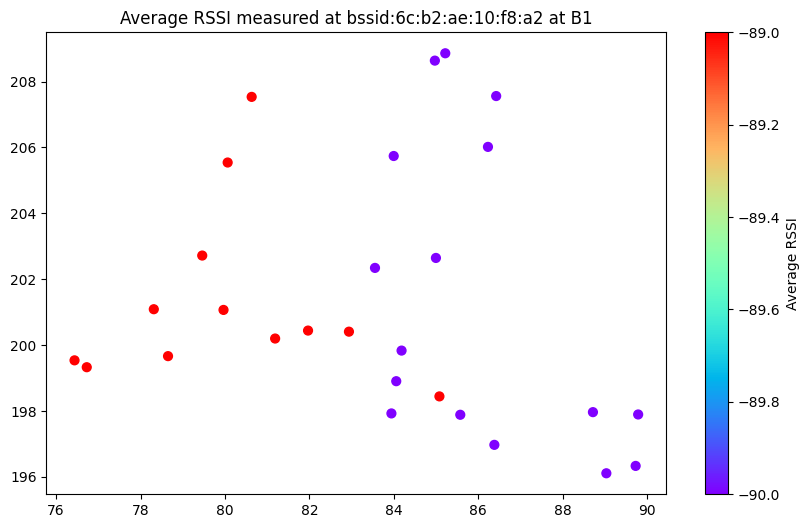

In [19]:
#two random router is selected for display
sampledRouters = random.sample(list(rssi_for_router.keys()), 2)
for bssid in sampledRouters:
    plotRSSIForRouter(bssid, rssi_for_router, selected_floor)